'''Part 1: JAX neural net basics '''


Loading the data


In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
print(f"{digits.data.shape=}")
print(f"{digits.target.shape=}")

digits.data.shape=(1797, 64)
digits.target.shape=(1797,)


This dataset consists of 8x8 pixelated images of hand-written digits and their corresponding labels. Let’s visualize a handful of them with matplotlib:

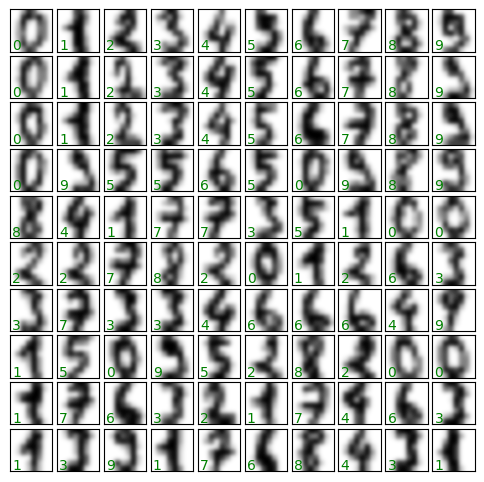

In [3]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='gaussian')
    ax.text(0.05, 0.05, str(digits.target[i]), transform=ax.transAxes, color='green')

Next, we split the dataset into a training and testing set, and convert these splits into jax.Arrays before we feed them into the model. We’ll use the jax.numpy module, which provides a familiar NumPy-style API around JAX operations:

In [4]:
from sklearn.model_selection import train_test_split
splits = train_test_split(digits.images, digits.target, random_state=0)

In [5]:
import jax.numpy as jnp
images_train, images_test, label_train, label_test = map(jnp.asarray, splits)
print(f"{images_train.shape=} {label_train.shape=}")
print(f"{images_test.shape=}  {label_test.shape=}")

images_train.shape=(1347, 8, 8) label_train.shape=(1347,)
images_test.shape=(450, 8, 8)  label_test.shape=(450,)


Defining the Flax model
We can now use Flax NNX to create a simple feed-forward neural network - subclassing flax.nnx.Module - with flax.nnx.Linear layers with scaled exponential linear unit (SELU) activation function using the built-in flax.nnx.selu:

In [6]:
from flax import nnx

class SimpleNN(nnx.Module):

  def __init__(self, n_features: int = 64, n_hidden: int = 100, n_targets: int = 10,
               *, rngs: nnx.Rngs):
    self.n_features = n_features
    self.layer1 = nnx.Linear(n_features, n_hidden, rngs=rngs)
    self.layer2 = nnx.Linear(n_hidden, n_hidden, rngs=rngs)
    self.layer3 = nnx.Linear(n_hidden, n_targets, rngs=rngs)

  def __call__(self, x):
    x = x.reshape(x.shape[0], self.n_features) # Flatten images.
    x = nnx.selu(self.layer1(x))
    x = nnx.selu(self.layer2(x))
    x = self.layer3(x)
    return x

model = SimpleNN(rngs=nnx.Rngs(0))

nnx.display(model)  # Interactive display if penzai is installed.

Training the model
With the SimpleNN model created and instantiated, we can now choose the loss function and the optimizer with the Optax package, and then define the training step function. Use:

optax.softmax_cross_entropy_with_integer_labels as the loss, as the output layer will have nodes corresponding to a handwritten integer label.

optax.sgd for the stochastic gradient descent optimizer.

flax.nnx.Optimizer to instantiate the optimizer and set the train state.

In [8]:
import jax
import optax

optimizer = nnx.ModelAndOptimizer(model, optax.sgd(learning_rate=0.05))

def loss_fun(
    model: nnx.Module,
    data: jax.Array,
    labels: jax.Array):
  logits = model(data)
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=labels
  ).mean()
  return loss, logits

@nnx.jit  # JIT-compile the function
def train_step(
    model: nnx.Module,
    optimizer: nnx.Optimizer,
    data: jax.Array,
    labels: jax.Array):
  loss_gradient = nnx.grad(loss_fun, has_aux=True)  # gradient transform!
  grads, logits = loss_gradient(model, data, labels)
  optimizer.update(grads)  # inplace update

In [9]:
for i in range(301):  # 300 training epochs
  train_step(model, optimizer, images_train, label_train)
  if i % 50 == 0:  # Print metrics.
    loss, _ = loss_fun(model, images_test, label_test)
    print(f"epoch {i}: loss={loss:.2f}")

epoch 0: loss=20.18
epoch 50: loss=0.21
epoch 100: loss=0.14
epoch 150: loss=0.12
epoch 200: loss=0.12
epoch 250: loss=0.11
epoch 300: loss=0.11


In [10]:
label_pred = model(images_test).argmax(axis=1)
num_matches = jnp.count_nonzero(label_pred == label_test)
num_total = len(label_test)
accuracy = num_matches / num_total
print(f"{num_matches} labels match out of {num_total}:"
      f" accuracy = {num_matches/num_total:%}")

433 labels match out of 450: accuracy = 96.222222%


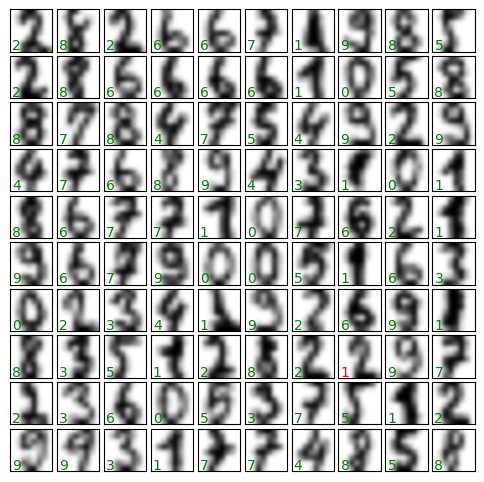

In [11]:
fig, axes = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(images_test[i], cmap='binary', interpolation='gaussian')
    color = 'green' if label_pred[i] == label_test[i] else 'red'
    ax.text(0.05, 0.05, str(label_pred[i]), transform=ax.transAxes, color=color)

In this tutorial, we have just scraped the surface with JAX, Flax NNX, and Optax here. The Flax NNX package includes a number of useful APIs for tracking metrics during training, which are features in the Flax MNIST tutorial on the Flax website.